![](img/563_banner.png)

# Lecture 7: Recommender Systems Part I

UBC Master of Data Science program, 2021-22

Instructor: Varada Kolhatkar

> People who agreed in the past are likely to agree again in future. <br>
-- [The Master Algorithm](https://www.amazon.ca/Master-Algorithm-Ultimate-Learning-Machine-ebook/dp/B012271YB2)


## Lecture plan, imports, and LOs

### Imports 

In [1]:
import os
import random
import sys
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, train_test_split

plt.rcParams["font.size"] = 16

%matplotlib inline
pd.set_option("display.max_colwidth", 0)

### Lecture plan  
 
- Motivation (~10 mins)
- Formulating the recommendation problem (~10 mins)
- Baseline approaches (~10 mins)
- Questions for class discussion (~5 mins)
- Break (~5 mins) 
- Collaborative filtering (~20 mins)
- Questions for class discussion (~5 mins)
- Summary and conclusion (~10 mins)

## Learning outcomes <a name="lo"></a>

From this lecture, students are expected to be able to:
- State the problem of recommender systems. 
- Describe components of a utility matrix. 
- Create a utility matrix given ratings data. 
- Describe a common approach to evaluate recommender systems. 
- Implement some baseline approaches to complete the utility matrix. 
- Explain the idea of collaborative filtering. 
- Describe how you can use a PCA-like model to fill in the utility matrix. 
- Explain how to interpret $Z$ and $W$ in the context of recommendation systems. 
- Explain how the loss function of collaborative filtering differs from the loss function of regular PCA. 
- Learn to be mindful of some serious consequences of recommendation systems. 

## Recommender systems motivation

### What is a recommender system? 

- A recommender or a recommendation system **recommends** a particular product or service to users they are likely to consume. 

<img src="img/recommendation_system.png" alt="" height="900" width="900"> 


### Example: Recommender Systems
- A user goes to Amazon to buy products. 
- Amazon has some information about the user. They also have information about other users buying similar products. 
- What should they recommend to the user, so that they buy more products? 
- There's no "right" answer (no label). 
- The whole idea is to understand user behavior in order to recommend them products they are likely to consume. 

### Why should we care about recommendation systems? 

- Almost everything we buy or consume today is in some way or the other influenced by recommendation systems. 
    - Music (Spotify), videos (YouTube), news, books and products (Amazon), movies (Netflix), jokes, restaurants, dating , friends (Facebook), professional connections (LinkedIn)
- Recommendation systems are at the core of the success of many companies. 
    - Amazon (1/3rd of their business comes from its recommendation systems)
    - [Netflix](https://help.netflix.com/en/node/100639) (3/4th of their business comes from its recommendation systems)


### Past MDS Capstone: [QxMD](https://qxmd.com/)

- Present personalized journal article recommendations to health care professionals.   

### What kind of data we need to build recommendation systems? 

- Customer purchase history data (We worked with it last week.)
- **User ratings data** (most common)
- **Features related to items or users** 

### Main approaches

- Collaborative filtering (today's focus)
    - "Unsupervised" learning 
    - We only have labels $y_{ij}$ (rating of user $i$ for item $j$). 
    - We learn features.  
- Content-based recommenders 
    - Supervised learning
    - Extract features $x_i$ of users and/or items building a model to predict rating $y_i$ given $x_i$. 
    - Apply model to predict for new users/items. 
- Hybrid 
    - Combining collaborative filtering with content-based filtering
    

### The Netflix prize

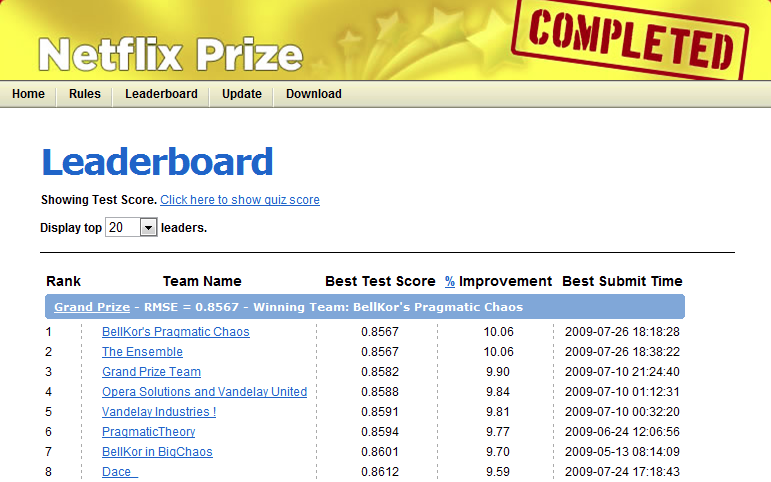

[Source](https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429)

### The Netflix prize

- 100M ratings from ~0.5M users on ~18k movies.
- Grand prize was \$1M for the first team to reduce squared error at least by 10%.
- Winning entry (and most entries) used collaborative filtering:
- A simple collaborative filtering method that does really well:
   - "Regularized matrix factorization". Now adopted by many companies.

<br><br><br><br>

## Recommender systems problem 

### Problem formulation

- Most often the data for recommender systems come in as **ratings** for a set of items from a set of users. 
- We have two entities: $N$ **users** and $M$ **items**. 
- **Users** are consumers. 
- **Items** are the products or services offered.  
    - E.g., movies (Netflix), books (Amazon), songs (spotify), people (tinder)  
    
<img src="img/utility_matrix.png" alt="" height="900" width="900"> 


### Utility matrix 

- A **utility matrix** is the matrix that captures **interactions** between $N$ **users** and $M$ **items**. 
- The interaction may come in different forms: 
    - ratings, clicks, purchases
    
<img src="img/utility_matrix.png" alt="" height="900" width="900"> 

### Utility matrix

- Below is a toy utility matrix. Here $N$ = 6 and $M$ = 5.  
- Each entry $y_{ij}$ ($i^{th}$ row and $j^{th}$ column) denotes the rating given by the user $i$ to item $j$. 
- We represent users in terms of items and items in terms of users. 

<img src="img/utility_matrix.png" alt="" height="900" width="900"> 


### Sparsity of utility matrix

- The utility matrix is very sparse because usually users only interact with a few items. 
- For example: 
    - all Netflix users will have rated only a small percentage of content available on Netflix
    - all amazon clients will have rated only a small fraction of items among all items available on Amazon

### What do we predict? 
Given a utility matrix of $N$ users and $M$ items, **complete the utility matrix**. In other words, **predict missing values in the matrix**. 

<img src="img/utility_matrix.png" alt="" height="900" width="900"> 


- Once we have predicted ratings, we can recommend items to users they are likely to rate higher. 

### Example dataset: [Jester 1.7M jokes ratings dataset](https://www.kaggle.com/vikashrajluhaniwal/jester-17m-jokes-ratings-dataset?select=jester_ratings.csv)

- We'll use a sample of [Jester 1.7M jokes ratings dataset](https://www.kaggle.com/vikashrajluhaniwal/jester-17m-jokes-ratings-dataset) to demonstrate different recommendation systems. 

The dataset comes with two CSVs
- A CSV containing ratings (-10.0 to +10.0) of 150 jokes from 59,132 users. 
- A CSV containing joke IDs and the actual text of jokes. 

> Some jokes might be offensive. Please do not look too much into the actual text data if you are sensitive to such language.

- Recommendation systems are most effective when you have a large amount of data.
- But we are only taking a sample here for speed.

In [2]:
filename = "data/jester_ratings.csv"
ratings_full = pd.read_csv(filename)
ratings = ratings_full[ratings_full["userId"] <= 4000]

In [3]:
ratings.head()

userId  jokeId  rating
0  1       5       0.219 
1  1       7      -9.281 
2  1       8      -9.281 
3  1       13     -6.781 
4  1       15      0.875

In [4]:
user_key = "userId"
item_key = "jokeId"

### Dataset stats 

In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 141362 entries, 0 to 141361
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   userId  141362 non-null  int64  
 1   jokeId  141362 non-null  int64  
 2   rating  141362 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 4.3 MB


In [6]:
def get_stats(ratings, item_key="jokeId", user_key="userId"):
    print("Number of ratings:", len(ratings))
    print("Average rating:  %0.3f" % (np.mean(ratings["rating"])))
    N = len(np.unique(ratings[user_key]))
    M = len(np.unique(ratings[item_key]))
    print("Number of users (N): %d" % N)
    print("Number of items (M): %d" % M)
    print("Fraction non-nan ratings: %0.3f" % (len(ratings) / (N * M)))
    return N, M


N, M = get_stats(ratings)

Number of ratings: 141362
Average rating:  1.200
Number of users (N): 3635
Number of items (M): 140
Fraction non-nan ratings: 0.278


The fraction of non-nan ratings is much lower in real-world problems. 

### Creating utility matrix

- Let's construct utility matrix with `number of users` rows and `number of items` columns from the ratings data. 
> Note we are constructing a non-sparse matrix for demonstration purpose here. In real life it's recommended that you work with sparse matrices. 

In [7]:
user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(ratings[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(ratings[item_key])))

- Why do we need all these mappers? 
    - We want to store the rating for user $i$ and item $j$ at $Y[i,j]$ location in the utility matrix. 
    - So we define `user_mapper` and `item_mapper` which map user and item ids to indices. 
    - Once we have predicted ratings for users and items, we want to be able to map it to the original user and item ids so that we recommend the right product to the right user. 
    - So we have `user_inverse_mapper` and `item_inverse_mapper` which map indices to original user and item ids.        

In [8]:
def create_Y_from_ratings(
    data, N, M, user_mapper, item_mapper, user_key="userId", item_key="jokeId"
):  # Function to create a dense utility matrix
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["rating"]

    return Y

### Utility matrix for Jester jokes ratings data
- Rows represent users.
- Columns represent items (jokes in our case).
- Each cell gives the rating given by the user to the corresponding joke. 
- Users are features for jokes and jokes are features for users.
- We want to predict the missing entries. 

In [9]:
Y_mat = create_Y_from_ratings(ratings, N, M, user_mapper, item_mapper)
Y_mat.shape

(3635, 140)

In [10]:
pd.DataFrame(Y_mat)

0      1      2      3      4      5      6      7      8      9  \
0     0.219 -9.281 -9.281 -6.781  0.875 -9.656 -9.031 -7.469 -8.719 -9.156   
1    -9.688  9.938  9.531  9.938  0.406  3.719  9.656 -2.688 -9.562 -9.125   
2    -9.844 -9.844 -7.219 -2.031 -9.938 -9.969 -9.875 -9.812 -9.781 -6.844   
3    -5.812 -4.500 -4.906 NaN    NaN    NaN    NaN    NaN    NaN    NaN      
4     6.906  4.750 -5.906 -0.406 -4.031  3.875  6.219  5.656  6.094  5.406   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
3630 NaN    -9.812 -0.062 NaN    NaN    NaN    NaN    NaN    NaN    NaN      
3631 NaN    -9.844  7.531 -9.719 -9.344  3.875  9.812  8.938  8.375 NaN      
3632 NaN    -1.906  3.969 -2.312 -0.344 -8.844  4.188 NaN    NaN    NaN      
3633 NaN    -8.875 -9.156 -9.156 NaN    NaN    NaN    NaN    NaN    NaN      
3634 NaN    -6.312  1.281 -3.531  2.125 -5.812  5.562 -6.062  0.125 NaN      

      ...  130  131    132  133  134  135  136  137  138  139  
0     ... NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1     ... NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2     ... NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3     ... NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4     ... NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...   ...  ..   ..   ..     ..   ..   ..   ..   ..   ..   ..   
3630  ... NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3631  ... NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3632  ... NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3633  ... NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3634  ... NaN  NaN   4.188 NaN  NaN  NaN  NaN  NaN  NaN  NaN   

[3635 rows x 140 columns]

<br><br><br><br>

## Baseline Approaches


- Recall that our goal is to predict missing entries in the utility matrix. 

In [11]:
pd.DataFrame(Y_mat)

0      1      2      3      4      5      6      7      8      9  \
0     0.219 -9.281 -9.281 -6.781  0.875 -9.656 -9.031 -7.469 -8.719 -9.156   
1    -9.688  9.938  9.531  9.938  0.406  3.719  9.656 -2.688 -9.562 -9.125   
2    -9.844 -9.844 -7.219 -2.031 -9.938 -9.969 -9.875 -9.812 -9.781 -6.844   
3    -5.812 -4.500 -4.906 NaN    NaN    NaN    NaN    NaN    NaN    NaN      
4     6.906  4.750 -5.906 -0.406 -4.031  3.875  6.219  5.656  6.094  5.406   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
3630 NaN    -9.812 -0.062 NaN    NaN    NaN    NaN    NaN    NaN    NaN      
3631 NaN    -9.844  7.531 -9.719 -9.344  3.875  9.812  8.938  8.375 NaN      
3632 NaN    -1.906  3.969 -2.312 -0.344 -8.844  4.188 NaN    NaN    NaN      
3633 NaN    -8.875 -9.156 -9.156 NaN    NaN    NaN    NaN    NaN    NaN      
3634 NaN    -6.312  1.281 -3.531  2.125 -5.812  5.562 -6.062  0.125 NaN      

      ...  130  131    132  133  134  135  136  137  138  139  
0     ... NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1     ... NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2     ... NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3     ... NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4     ... NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...   ...  ..   ..   ..     ..   ..   ..   ..   ..   ..   ..   
3630  ... NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3631  ... NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3632  ... NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3633  ... NaN  NaN  NaN    NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3634  ... NaN  NaN   4.188 NaN  NaN  NaN  NaN  NaN  NaN  NaN   

[3635 rows x 140 columns]

### Evaluation

- We'll try a number of methods to fill in the missing entries in the utility matrix.
- Although there is no notion of "accurate" recommendations, we need a way to evaluate our predictions so that we'll be able to compare different methods.
- Although we are doing unsupervised learning, we'll split the data and evaluate our predictions as follows.  

### Data splitting 

- We split the ratings into train and validation sets. 
- It's easier to split the ratings data instead of splitting the utility matrix.
- Don't worry about `y`; we're not really going to use it.  

In [12]:
X = ratings.copy()
y = ratings[user_key]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_valid.shape

((113089, 3), (28273, 3))

Now we will create utility matrices for train and validation splits. 

In [13]:
train_mat = create_Y_from_ratings(X_train, N, M, user_mapper, item_mapper)
valid_mat = create_Y_from_ratings(X_valid, N, M, user_mapper, item_mapper)

In [14]:
train_mat.shape, valid_mat.shape

((3635, 140), (3635, 140))

In [15]:
(len(X_train) / (N * M)) # Fraction of non-nan entries in the train set

0.22222244055806642

In [16]:
(len(X_valid) / (N * M)) # Fraction of non-nan entries in the valid set

0.055557083906464924

- `train_mat` has only ratings from the train set and `valid_mat` has only ratings from the valid set.
- During training we assume that we do not have access to some of the available ratings. We predict these ratings and evaluate them against ratings in the validation set. 

### Questions for you

- How do train and validation utility matrices differ? 
- Why are utility matrices for train and validation sets are of the same shape?
<br><br>

**Answer:**

- The training matrix `train_mat` is of shape N by M but only has ratings from `X_train` and all other ratings missing. 
- The validation matrix `valid_mat` is also of shape N by M but it only has ratings from `X_valid` and all other ratings missing. 
- They have the same shape because both have the same number of users and items; that's how we have constructed them. 

### Evaluation

- Now that we have train and validation sets, how do we evaluate our predictions?
- You can calculate the error between actual ratings and predicted ratings with metrics of your choice. 
    - Most common ones are MSE or RMSE. 

- The `error` function below calculates RMSE and `evaluate` function prints train and validation RMSE.  

In [17]:
def error(X1, X2):
    """
    Returns the root mean squared error.
    """
    return np.sqrt(np.nanmean((X1 - X2) ** 2))


def evaluate(pred_X, train_X, valid_X, model_name="Global average"):
    print("%s train RMSE: %0.2f" % (model_name, error(pred_X, train_X)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_X, valid_X)))

<br><br>

### Baselines

Let's first try some simple approaches to predict missing entries. 

1. Global average baseline
2. Per-user average baseline
3. Per-item average baseline
4. Average of 2 and 3
    - Take an average of per-user and per-item averages. 
5. [$k$-Nearest Neighbours imputation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)    
    
I'll show you 1. and 5. You'll explore 2., 3., and 4. in the lab. 

### Global average baseline

- Let's examine RMSE of the global average baseline. 
- In this baseline we predict everything as the global average rating.

In [18]:
avg = np.nanmean(train_mat)
pred_g = np.zeros(train_mat.shape) + avg
pd.DataFrame(pred_g).head()

0        1        2        3        4        5        6        7  \
0  1.20741  1.20741  1.20741  1.20741  1.20741  1.20741  1.20741  1.20741   
1  1.20741  1.20741  1.20741  1.20741  1.20741  1.20741  1.20741  1.20741   
2  1.20741  1.20741  1.20741  1.20741  1.20741  1.20741  1.20741  1.20741   
3  1.20741  1.20741  1.20741  1.20741  1.20741  1.20741  1.20741  1.20741   
4  1.20741  1.20741  1.20741  1.20741  1.20741  1.20741  1.20741  1.20741   

         8        9  ...      130      131      132      133      134  \
0  1.20741  1.20741  ...  1.20741  1.20741  1.20741  1.20741  1.20741   
1  1.20741  1.20741  ...  1.20741  1.20741  1.20741  1.20741  1.20741   
2  1.20741  1.20741  ...  1.20741  1.20741  1.20741  1.20741  1.20741   
3  1.20741  1.20741  ...  1.20741  1.20741  1.20741  1.20741  1.20741   
4  1.20741  1.20741  ...  1.20741  1.20741  1.20741  1.20741  1.20741   

       135      136      137      138      139  
0  1.20741  1.20741  1.20741  1.20741  1.20741  
1  1.20741  1.20741  1.20741  1.20741  1.20741  
2  1.20741  1.20741  1.20741  1.20741  1.20741  
3  1.20741  1.20741  1.20741  1.20741  1.20741  
4  1.20741  1.20741  1.20741  1.20741  1.20741  

[5 rows x 140 columns]

In [19]:
evaluate(pred_g, train_mat, valid_mat, model_name="Global average")

Global average train RMSE: 5.75
Global average valid RMSE: 5.77


### [$k$-nearest neighbours imputation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)

- Can we try $k$-nearest neighbours type imputation? 
- Impute missing values using the mean value from $k$ nearest neighbours found in the training set. 
- Calculate distances between examples using features where neither value is missing. 

<img src="img/utility_matrix.png" alt="" height="900" width="900"> 

In [20]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=10)
train_mat_imp = imputer.fit_transform(train_mat)

In [21]:
pd.DataFrame(train_mat_imp)

0       1       2       3       4       5       6       7       8  \
0    -5.9406 -9.2810 -9.2810 -6.7810  0.8750 -9.6560 -9.0310 -7.4690 -8.7190   
1     2.3405  9.9380  9.5310  9.9380  0.4060  3.7190  9.6560 -2.6880  4.3438   
2    -9.8440 -3.5750 -7.2190 -2.0310 -9.9380 -9.9690 -9.8750 -9.8120 -9.7810   
3    -5.8120 -2.4624 -4.9060 -2.7781 -0.0532 -3.8594  1.7031 -0.3687  1.8469   
4     1.3157  4.7500  1.8658 -0.4060  1.7937  3.8750  6.2190  1.9220  6.0940   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
3630 -0.7750 -9.8120 -0.0620 -2.8218 -4.1470 -4.8281  2.2718 -2.8782 -1.0125   
3631  2.5188 -5.0625 -0.4001 -9.7190 -9.3440 -1.6408 -4.1187  8.9380  8.3750   
3632  0.1749 -1.9060  3.9690 -1.3844 -0.3440 -8.8440  4.1880 -1.5564  5.0593   
3633 -4.5937 -6.4907 -6.1594 -9.1560 -7.1437 -6.5406  3.8718 -1.7782 -3.7406   
3634 -0.0812 -6.3120  1.2810 -3.5310  2.1250 -5.8120  5.5620  0.2218  0.1250   

           9  ...     130     131     132     133     134     135     136  \
0    -9.1560  ... -4.5311  1.8968  0.6905 -3.1218  1.2843 -2.6063 -0.1812   
1    -9.1250  ...  2.2437  3.1719  5.0251  5.1812  8.2407  5.9311  5.8375   
2    -6.8440  ... -4.4186 -3.1156 -1.5655 -5.6250  0.3720 -4.0439 -6.0500   
3     0.0593  ... -2.0344  2.1469  2.8875  1.6845  1.2437 -0.0156  1.2595   
4     5.4060  ... -0.2844  1.1313  4.0157  3.0344  4.0406  0.5218  4.3594   
...      ...  ...     ...     ...     ...     ...     ...     ...     ...   
3630  0.0688  ... -6.6844  3.0531  2.8687  1.5281  4.5002 -0.1878  2.0031   
3631 -0.9314  ... -4.0344  7.9155  3.4282  4.2968  6.7968  7.3999  1.8500   
3632  0.3343  ... -4.0126  2.8344  2.4499  2.9312  2.3750 -0.4062  1.4375   
3633 -0.6406  ... -4.6938  4.8061  4.9968 -0.1626  2.4187 -0.7750  4.6781   
3634 -1.1874  ... -3.8156  4.1812  4.1880  3.7280  3.0750  2.1033  2.8156   

         137     138     139  
0    -1.3937  1.7625 -0.4092  
1     6.3812  1.1687  6.2532  
2    -5.5563 -5.4125 -5.5874  
3     3.8219  3.1971  5.0249  
4     4.0968  3.9250  3.9657  
...      ...     ...     ...  
3630  4.0908  2.3563  5.0406  
3631  5.8219  5.1812  2.8437  
3632  3.9750 -1.2220  2.8375  
3633  1.7658  0.4595  0.1843  
3634  5.5312  3.8283  4.1219  

[3635 rows x 140 columns]

In [22]:
evaluate(train_mat_imp, train_mat, valid_mat, model_name="KNN imputer")

KNN imputer train RMSE: 0.00
KNN imputer valid RMSE: 4.79


### Exercise for you

- Implement other baselines for practice and report train and validation RMSE.  

### (Optional) Finding [nearest neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html)

- We can look at nearest neighbours of a query item. 
- Here our columns are jokes, and users are features for jokes, and we'll have to find nearest neighbours of columns vectors. 

In [23]:
pd.DataFrame(train_mat_imp).head()

0       1       2       3       4       5       6       7       8  \
0 -5.9406 -9.2810 -9.2810 -6.7810  0.8750 -9.6560 -9.0310 -7.4690 -8.7190   
1  2.3405  9.9380  9.5310  9.9380  0.4060  3.7190  9.6560 -2.6880  4.3438   
2 -9.8440 -3.5750 -7.2190 -2.0310 -9.9380 -9.9690 -9.8750 -9.8120 -9.7810   
3 -5.8120 -2.4624 -4.9060 -2.7781 -0.0532 -3.8594  1.7031 -0.3687  1.8469   
4  1.3157  4.7500  1.8658 -0.4060  1.7937  3.8750  6.2190  1.9220  6.0940   

        9  ...     130     131     132     133     134     135     136  \
0 -9.1560  ... -4.5311  1.8968  0.6905 -3.1218  1.2843 -2.6063 -0.1812   
1 -9.1250  ...  2.2437  3.1719  5.0251  5.1812  8.2407  5.9311  5.8375   
2 -6.8440  ... -4.4186 -3.1156 -1.5655 -5.6250  0.3720 -4.0439 -6.0500   
3  0.0593  ... -2.0344  2.1469  2.8875  1.6845  1.2437 -0.0156  1.2595   
4  5.4060  ... -0.2844  1.1313  4.0157  3.0344  4.0406  0.5218  4.3594   

      137     138     139  
0 -1.3937  1.7625 -0.4092  
1  6.3812  1.1687  6.2532  
2 -5.5563 -5.4125 -5.5874  
3  3.8219  3.1971  5.0249  
4  4.0968  3.9250  3.9657  

[5 rows x 140 columns]

### (Optional) $k$-nearest neighbours on a query joke
- Let's transpose the matrix.  

In [24]:
item_user_mat = train_mat_imp.T

In [25]:
jokes_df = pd.read_csv("data/jester_items.csv")
jokes_df.head()

jokeId  \
0  1        
1  2        
2  3        
3  4        
4  5        

                                                                                                                                                                                                                                                                                                                                                                                                   jokeText  
0  A man visits the doctor. The doctor says "I have bad news for you.You have\ncancer and Alzheimer's disease". \nThe man replies "Well,thank God I don't have cancer!"\n                                                                                                                                                                                                                                    
1  This couple had an excellent relationship going until one day he came home\nfrom work to find his girlfriend packing. He asked her why she was leaving him\nand she told him that she had heard awful things about him. \n\n"What could they possibly have said to make you move out?" \n\n"They told me that you were a pedophile." \n\nHe replied, "That's an awfully big word for a ten year old." \n  
2  Q. What's 200 feet long and has 4 teeth? \n\nA. The front row at a Willie Nelson Concert.\n                                                                                                                                                                                                                                                                                                               
3  Q. What's the difference between a man and a toilet? \n\nA. A toilet doesn't follow you around after you use it.\n                                                                                                                                                                                                                                                                                        
4  Q.\tWhat's O. J. Simpson's Internet address? \nA.\tSlash, slash, backslash, slash, slash, escape.\n

In [26]:
id_joke_map = dict(zip(jokes_df.jokeId, jokes_df.jokeText))

In [27]:
from sklearn.neighbors import NearestNeighbors


def get_topk_recommendations(X, query_ind=0, metric="cosine", k=5):
    query_idx = item_inverse_mapper[query_ind]
    model = NearestNeighbors(n_neighbors=k, metric="cosine")
    model.fit(X)
    neigh_ind = model.kneighbors([X[query_ind]], k, return_distance=False).flatten()
    neigh_ind = np.delete(neigh_ind, np.where(query_ind == query_ind))
    recs = [id_joke_map[item_inverse_mapper[i]] for i in neigh_ind]
    print("Query joke: ", id_joke_map[query_idx])

    return pd.DataFrame(data=recs, columns=["top recommendations"])


get_topk_recommendations(item_user_mat, query_ind=8, metric="cosine", k=5)

Query joke:  Q: If a person who speaks three languages is called "tri-lingual," and
a person who speaks two languages is called "bi-lingual," what do call
a person who only speaks one language?

A: American! 



top recommendations
0  Q: What is the difference between George  Washington, Richard Nixon,\nand Bill Clinton?\n\nA: Washington couldn't tell a lie, Nixon couldn't   tell the truth, and\nClinton doesn't know the difference.\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
1  A man in a hot air balloon realized he was lost. He reduced altitude and spotted a woman below. He descended a bit more and shouted, "Excuse me, can you help me? I promised a friend I would meet him an hour ago, but I don't know where I am." The woman below replied, "You are in a hot air balloon hovering approximately 30 feet above the ground. You are between 40 and 41 degrees north latitude and between 59 and 60 degrees west longitude." "You must be an engineer," said the balloonist. "I am," replied the woman. "How did you know?" "Well," answered the balloonist, "everything you told me is technically correct, but I have no idea what to make of your information, and the fact is, I am still lost. Frankly, you've not been much help so far." The woman below responded, "You must be in management." "I am," replied the balloonist, "but how did you know?" "Well," said the woman, "you don't know where you are or where you are going. You have risen to where you are due to a large quantity of hot air. You made a promise that you have no idea how to keep, and you expect people beneath you to solve your problems. The fact is, you are in exactly the same position you were in before we met, but now, somehow, it's my fault!"
2  If pro- is the opposite of con- then congress must be the opposite\nof progress.\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
3  Arnold Swartzeneger and Sylvester Stallone are making a movie about\nthe lives of the great composers.  \nStallone says "I want to be Mozart." \nSwartzeneger says: "In that case...  I'll be Bach."\n

**Question**
- Instead of imputation, what would be the consequences if we replace `nan` with zeros so that we can calculate distances between vectors? 

<br><br>
**Answer**

It's not a good idea replace ratings with 0, because 0 can be an actual rating value in our case. 

### What to do with predictions? 
- Once you have predictions, you can sort them based on ratings and recommend items with highest ratings.  

<br><br><br><br>

## ❓❓ Questions for you
iClicker cloud join link: https://join.iclicker.com/MA16T

### Exercise 7.1 Select all of the following statements which are **True** (iClicker)

- (A) In the context of recommendation systems, the shapes of validation utility matrix and train utility matrix are the same. 
- (B) RMSE perfectly captures what we want to measure in the context of recommendation systems. 
- (C) It would be reasonable to impute missing values in the utility matrix by taking the average of the ratings given to an item by similar users.  
- (D) It might be reasonable to create embedding representations of jokes and finding similar jokes to a given joke using cosine similarity. 
- (E) In KNN type imputation, if a user has not rated any items yet, a reasonable strategy would be recommending them the most popular item. 

<br><br><br><br>

```{admonition} Exercise 7.1: V's Solutions!
:class: tip, dropdown

- (A) True
- (B) False
- (C) True
- (D) True 
- (E) True
```

### Questions for class discussion

For each of the following methods, discuss how it might be applied to the problem of item recommendation:

1. Clustering
> If you cluster items, you could recommend other items in the same cluster when someone looks at a particular item. You could also try clustering users and recommending items to a user based on users in the same cluster.

2. Graphs and breadth-first search
> You could make a graph where two items are connected if they share a user in common (e.g. a user that bought both, or reviewed both, or some other criterion). Then if you run BFS starting from that node, you'd explore similar items -- from most similar to least similar because it's breadth-first.

<br><br><br><br>

## Collaborative filtering 

### Collaborative filtering 
- One of the most popular approach for recommendation systems. 
- Approach used by the winning entry (and most of the entries) in the Netflix competition. 
- An unsupervised approach
    - Only uses the user-item interactions given in the ratings matrix. 

### Intuition
- **People who agreed in the past are likely to agree again in future.** 
- We may have similar users and similar items which can help us predict missing entries. 
- Leverage social information to provide recommendations. 

### Problem 

- Given a utility matrix with many missing entries, how can we predict missing ratings?  

$$
\begin{bmatrix} 
? & ? & \checkmark  & ? & \checkmark\\
\checkmark & ? & ?  & ? & ?\\
? & \checkmark & \checkmark  & ? & \checkmark\\
? & ? & ?  & ? & ?\\
? & ? & ? & \checkmark & ?\\
? & \checkmark & \checkmark  & ? & \checkmark
\end{bmatrix}
$$

> Note: rating prediction $\neq$ Classification or regression 

### Classification or regression

- We have $X$ and targets for some rows in $X$. 
- We want to predict the last column (target column).  

$$
\begin{bmatrix} 
\checkmark & \checkmark & \checkmark  & \checkmark & \checkmark\\
\checkmark & \checkmark & \checkmark  & \checkmark & \checkmark\\
\checkmark & \checkmark & \checkmark  & \checkmark & \checkmark\\
\checkmark & \checkmark & \checkmark  & \checkmark & ?\\
\checkmark & \checkmark & \checkmark  & \checkmark & ?\\
\checkmark & \checkmark & \checkmark  & \checkmark & ?\\
\end{bmatrix}
$$

### Rating prediction 

- Ratings data has many missing values in the utility matrix. There is no special target column. We want to predict the missing entries in the matrix. 
- Since our goal is to **predict** ratings, usually the utility matrix is referred to as $Y$ matrix. 

$$
\begin{bmatrix} 
? & ? & \checkmark  & ? & \checkmark\\
\checkmark & ? & ?  & ? & ?\\
? & \checkmark & \checkmark  & ? & \checkmark\\
? & ? & ?  & ? & ?\\
? & ? & ? & \checkmark & ?\\
? & \checkmark & \checkmark  & ? & \checkmark
\end{bmatrix}
$$


### Can we use something like PCA?
- We are not exactly interested in individual ratings or clicks. We want to find users with similar tastes. 
- So we want to learn some latent features related to typical users and typical items. 
- We have used PCA/LSA to extract meaningful features before. 
- Can we use the same idea here? Yes! 
- Collaborative filtering main idea
    - Run **PCA-like** algorithm on the utility matrix to learn latent features related to typical users and typical items. 
    - Use **reconstructions** to fill in missing entries.

### Toy movie recommendation example

- It's a bit hard to create a toy example with jokes. 
- So let's walk through a movie recommendation toy example. 
- The toy data below contains movie ratings for a few movies given by 4 users. 

In [28]:
toy_ratings = pd.read_csv("data/toy-movie-ratings.csv")
toy_ratings

user_id            movie_id  rating
0   Sam     Lion King           5     
1   Sam     Toy Story           4     
2   Sam     The Little Mermaid  5     
3   Sam     Bambi               5     
4   Sam     The Social Dilemma  1     
5   Eva     Toy Story           1     
6   Eva     The Social Dilemma  5     
7   Eva     Man on Wire         5     
8   Pat     The Little Mermaid  4     
9   Pat     Lion King           5     
10  Pat     Bambi               5     
11  Jim     The Social Dilemma  5     
12  Jim     Malcolm x           4     
13  Jim     Man on Wire         5

Let's create the utility matrix.  

In [29]:
N_toy = len(np.unique(toy_ratings["user_id"]))
M_toy = len(np.unique(toy_ratings["movie_id"]))
print("Number of users (N)                : %d" % N_toy)
print("Number of movies (M)               : %d" % M_toy)

Number of users (N)                : 4
Number of movies (M)               : 7


In [30]:
user_mapper_toy = dict(zip(np.unique(toy_ratings["user_id"]), list(range(N_toy))))
item_mapper_toy = dict(zip(np.unique(toy_ratings["movie_id"]), list(range(M_toy))))
user_inverse_mapper_toy = dict(
    zip(list(range(N_toy)), np.unique(toy_ratings["user_id"]))
)
item_inverse_mapper_toy = dict(
    zip(list(range(M_toy)), np.unique(toy_ratings["movie_id"]))
)

In [31]:
Y_toy = create_Y_from_ratings(
    toy_ratings, N_toy, M_toy, user_mapper_toy, item_mapper_toy, user_key="user_id", item_key="movie_id"
)
utility_mat_toy = pd.DataFrame(
    Y_toy, columns=item_mapper_toy.keys(), index=user_mapper_toy.keys()
)
utility_mat_toy

Bambi  Lion King  Malcolm x  Man on Wire  The Little Mermaid  \
Eva NaN    NaN        NaN         5.0         NaN                   
Jim NaN    NaN         4.0        5.0         NaN                   
Pat  5.0    5.0       NaN        NaN           4.0                  
Sam  5.0    5.0       NaN        NaN           5.0                  

     The Social Dilemma  Toy Story  
Eva  5.0                 1.0        
Jim  5.0                NaN         
Pat NaN                 NaN         
Sam  1.0                 4.0

- In this toy example, we see clear groups of movies and users.
    - For movies: Children movies and documentaries 
    - For users: Children movie lovers and documentary lovers  
- How can we identify such latent features?
    - Can we use PCA or LSA (`TruncatedSVD`)? 

In [32]:
from sklearn.decomposition import PCA, TruncatedSVD

data_toy = utility_mat_toy.to_numpy()
model_toy = TruncatedSVD(n_components=2, random_state=42)

In [33]:
# model_toy.fit(data_toy) # This won't work.

- We have missing data and we need to impute it to some numeric values so that we can train `TruncatedSVD` on it.  
- How about replacing missing data with zeros? 

In [34]:
data_svd_toy = np.nan_to_num(data_toy)  # replace all nan values with zeros
model_toy = TruncatedSVD(n_components=2, random_state=42)
model_toy.fit(data_svd_toy)

TruncatedSVD(random_state=42)

- Let's look at the transformed data $Z$. 
- $Z$ maps users to latent features of items.
- Each row of $Z$ is a new representation of a user with latent features of items.
- In our case the latent features of items can be named as **Children movies** and **Documentaries**.   

In [35]:
Z_toy = model_toy.transform(data_svd_toy)
Z_df = pd.DataFrame(
    Z_toy, index=user_mapper_toy.keys(), columns=["Children movies??", "Documentaries??"]
)
Z_df 

Children movies??  Documentaries??
Eva  1.568008           6.643711       
Jim  1.464664           7.768158       
Pat  7.676307          -1.635912       
Sam  9.382274          -0.984556

- Let's look at $W$. 
- $W$ maps items to latent features of users.
- Each column of $W$ is a new representation of an item with latent features of users. 
- In our case the latent features of users can be named as **Children movie lovers** and **Documentary lovers**.   

In [36]:
W_toy = model_toy.components_

In [37]:
W_df = pd.DataFrame(
    W_toy,
    columns=item_mapper_toy.keys(),
    index=["Children movie lovers??", "Documentary lovers??"],
)
W_df

Bambi  Lion King  Malcolm x  Man on Wire  \
Children movie lovers??  0.562779  0.562779   0.038657   0.100051      
Documentary lovers??    -0.121174 -0.121174   0.287367   0.666422      

                         The Little Mermaid  The Social Dilemma  Toy Story  
Children movie lovers??  0.512129            0.161957            0.257970   
Documentary lovers??    -0.106044            0.657316            0.025021

In recommendation systems, items are features of users and users are features of items. So we can also think of $W$ as representation of each movie in terms of latent features of users. 

In [38]:
W_df.T

Children movie lovers??  Documentary lovers??
Bambi               0.562779                -0.121174            
Lion King           0.562779                -0.121174            
Malcolm x           0.038657                 0.287367            
Man on Wire         0.100051                 0.666422            
The Little Mermaid  0.512129                -0.106044            
The Social Dilemma  0.161957                 0.657316            
Toy Story           0.257970                 0.025021

In [39]:
Z_df.T

Eva       Jim       Pat       Sam
Children movies??  1.568008  1.464664  7.676307  9.382274
Documentaries??    6.643711  7.768158 -1.635912 -0.984556

- We can get rating predictions if we get reconstructions by multiplying $Z$ and $W$. 

### PCA on ratings matrix 

- Given utility matrix $Y$ and number of components $k$ (the number of latent features), PCA factorizes the utility matrix $Y$ into $Z$ and $W$. 

$$Y_{N \times M} \approx Z_{N \times k} W_{k \times M}$$ 

<img src="img/PCA-collab-filtering.png" alt="" height="900" width="900"> 

### Interpreting $Z$ and $W$ in collaborative filtering

Although mathematically we are using the same model here the interpretation of the output is quite different. 

- When we talked about PCA before we assumed a clear distinction between features and examples. 
- We thought of $Z$ as transformed features and $W$ as basis vectors. 
- In recommendation systems, there is no clear distinction between examples and features. 
    - Users are features for items and items are features for users. 

### Interpreting $Z$ and $W$ in collaborative filtering

- The $k$ components can be thought of as capturing some semantic aspect of the original features. 
- Example
    - They may correspond to joke topics such as politics, technology, science, culture, religion. 
    
<img src="img/PCA-collab-filtering.png" alt="" height="600" width="600"> 


### Interpreting $Z$ and $W$ in collaborative filtering

- $Z$ maps **users to latent features of items**. 
    - Each row of $Z$ is a new representation of a user with latent features of items. 
- $W$ maps **items to latent features of users**. 
    - Each column of $W$ is a new representation of an item with latent features of users. 
    
<img src="img/PCA-collab-filtering.png" alt="" height="800" width="800"> 

### Example: Latent features for users 

- In the original space we represent a user in terms of all items (jokes). 
- In the new space we represent them using the latent features extracted by PCA for items. 
- Each column of $Z$ corresponds to latent feature for **items**. 
- You can represent users as: 
    - User Sam = 20% politics jokes fan + 10% science jokes fan + 50% culture jokes fan + ...
    - User Jamie = 50% politics jokes fan + 20% religion jokes fan + 5% culture jokes fan + ...

<img src="img/PCA-collab-filtering.png" alt="" height="600" width="600"> 

### Example: Latent features for items 
- In the original space we represent an item in terms of all users. 
- In the new space we represent them using the latent features extracted by PCA.
- Each row of $W$ corresponds to a latent feature for **users**. 
<img src="img/PCA-collab-filtering.png" alt="" height="600" width="600"> 

### `TruncatedSVD` for matrix factorization 

- Since we have many missing entries, `TruncatedSVD` seems more appropriate than the standard PCA to factorize the utility matrix.     
- This is the overall intuition but there are a few things we need to be careful about.     
    - Is it alright to replace all the missing entries with zeros? 

<br><br>

### Representing missing entries

- Recall loss function of PCA. 

$$f(Z, W) = \sum_{i=1}^{n} \lVert{W^Tz_i - y_i}\rVert^2_2 $$

- $W^Tz_i \rightarrow$ reconstructed rating 
- $y_i \rightarrow$ original rating 

- The problem with using regular PCA here is that 
    - we have many missing entries
    - and the loss function will be dominated by large number of entries which are not part of the real data


### Representing missing entries
 
- This is problematic especially because most of the entries in the utility matrix are missing. 
- So in the context of recommendation systems, a slightly modified loss function is used where we only **sum over the available ratings in $R$**.

$$f(Z, W) = \sum_{(i,j) \in R} ((w_j^Tz_i) - y_{ij})^2$$ 


### Adding regularization terms

- Add L2 regularization to both types of features. 
- Fit with stochastic gradient descent (SGD). 

$$f(Z, W) = \sum_{(i,j) \in R} ((w_i^Tz_i) - y_{ij})^2 + \frac{\lambda_1}{2}\lVert Z \lVert^2 + \frac{\lambda_2}{2}\lVert W \lVert^2$$

- This regularized SVD gave 7% improvement on the Netflix problem! 

### (Optional) Adding Global/User/Item biases

- Our standard latent-factor model gives reconstructions for entries in matrix $Y$ as 

$$\hat{y}_{ij} = w^T_jz_i$$

- Sometimes we don't assume the $y_{ij}$ have a mean of zero. 
- We could add bias $\beta$ reflecting average overall rating:

$$\hat{y}_{ij} = \beta + w^T_jz_i$$

- We could add user-specific bias $\beta_i$ and item-specific bias $\beta_j$

$$\hat{y}_{ij} = \beta + \beta_i + \beta_j + w^T_jz_i$$

- Some users rate things higher on average and some movies are rated higher on average. 
- The bias terms can also be regularized. 

<br><br>

### `surprise` package for rating prediction 

- Since our loss function is slightly different, we cannot really use PCA or LSA implementations in `scikit-learn`. 
- We'll be using a package called [Surprise](https://surprise.readthedocs.io/en/stable/index.html). 

```
conda install -c conda-forge scikit-surprise
```

- [This package](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#matrix-factorization-based-algorithms) implements the famous SVD algorithm popularized during Netflix Prize. 
- The loss function above is minimized using stochastic gradient descent. 

Let's try it out on our Jester dataset utility matrix.  

In [40]:
import surprise
from surprise import SVD, Dataset, Reader, accuracy

In [41]:
reader = Reader()
data = Dataset.load_from_df(ratings, reader)  # Load the data

# I'm being sloppy here. Probably there is a way to create validset from our already split data.
trainset, validset = surprise.model_selection.train_test_split(
    data, test_size=0.2, random_state=42
)  # Split the data

### Let's try regularized SVD 

In [42]:
k = 10
algo = SVD(n_factors=k, random_state=42)
algo.fit(trainset)
svd_preds = algo.test(validset)
accuracy.rmse(svd_preds, verbose=True)

RMSE: 5.2893


5.28926338380112

- No big improvement over the global baseline (RMSE=5.77). 
- Probably because we are only considering a sample. 

### Cross-validation for recommender systems

- We can also carry out cross-validation and grid search with this package. 
- Let's look at an example of cross-validation. 

In [43]:
from surprise.model_selection import cross_validate

pd.DataFrame(cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True))

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    5.2965  5.2566  5.2940  5.2681  5.2916  5.2814  0.0160  
MAE (testset)     4.2155  4.1823  4.2026  4.1852  4.2057  4.1982  0.0126  
Fit time          3.84    9.67    4.46    6.36    6.28    6.12    2.03    
Test time         0.47    0.51    0.61    1.43    0.48    0.70    0.37    


test_rmse  test_mae  fit_time  test_time
0  5.296532   4.215488  3.836111  0.473603 
1  5.256558   4.182293  9.671803  0.505056 
2  5.294026   4.202610  4.463865  0.608487 
3  5.268070   4.185187  6.356942  1.434076 
4  5.291566   4.205660  6.278505  0.476081

- Jester dataset is available as one of the built-in datasets in this package and you can load it as follows and run cross-validation as follows. 

In [44]:
data = Dataset.load_builtin("jester")

pd.DataFrame(cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True))

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4.5645  4.5438  4.5705  4.5736  4.5704  4.5646  0.0108  
MAE (testset)     3.3140  3.2977  3.3125  3.3222  3.3153  3.3123  0.0080  
Fit time          51.36   47.22   42.46   34.17   36.68   42.38   6.39    
Test time         8.43    5.49    5.20    5.73    5.44    6.06    1.20    


test_rmse  test_mae   fit_time  test_time
0  4.564524   3.313960  51.359054  8.430344 
1  4.543797   3.297719  47.223257  5.494843 
2  4.570461   3.312519  42.456848  5.202459 
3  4.573559   3.322162  34.168857  5.729691 
4  4.570428   3.315266  36.677360  5.443182

<br><br><br><br>

## Final comments and summary

### Formulating the problem of recommender systems 

- We are given ratings data. 
- We use this data to create **utility matrix** which encodes interactions between users and items. 
- The utility matrix has many missing entries. 
- We defined recommendation systems problem as **matrix completion problem**. 

### Collaborative filtering 

- Collaborative filtering is an unsupervised approach to recommendation systems. 
- Surprisingly we use PCA-like approach.  
- We factorize the utility matrix into $Z$ and $W$.
- Columns in $Z$ represent latent features of items. 
- Rows in $W$ represent latent features of users. 
- The key idea is that the loss function only includes the available ratings. 

### Evaluation 

- We split the data similar to supervised systems. 
- We evaluate recommendation systems using traditional regression metrics such as MSE or RMSE. 
- But real evaluation of recommender system can be very tricky because there is no ground truth. 
- We have been using RMSE due to the lack of a better measure.  
- What we actually want to measure is the interest that our user has in the recommended items. 

### Precision at N

- Another popular evaluation metric from information retrieval is precision at N. 
- Suppose you recommend top-N items, then we look at the proportion of the items that are relevant. 
$$\text{Precision at } N = \frac{r}{N}$$
- For example, $r$ could be the number of elements in your list that the user rated.
- In this way, you would know that your system is recommending items that the user had interest in!

### Some thoughts on recommendation systems  
- Be mindful of the consequences recommendation systems. 
- Companies such as Amazon,  Netflix, Facebook, Google (YouTube), which extensively use recommendation systems, are profit-driven and so they design these systems to maximize user attention; their focus is not necessarily human well-being. 
- There are tons of news and research articles on serious consequences of recommendation systems.  

### Some thoughts on recommendation systems  

- Some weird stories which got media attention.   
[How Target Figured Out A Teen Girl Was Pregnant Before Her Father Did](https://www.forbes.com/sites/kashmirhill/2012/02/16/how-target-figured-out-a-teen-girl-was-pregnant-before-her-father-did/?sh=3171af136668)
- More serious consequences are in political contexts. 
    - [Facebook Admits It Was Used to Incite Violence in Myanmar](https://www.nytimes.com/2018/11/06/technology/myanmar-facebook.html)
    - [YouTube Extremism and the Long Tail](https://www.theatlantic.com/politics/archive/2018/03/youtube-extremism-and-the-long-tail/555350/)    

### My advice

- Ask hard and uncomfortable questions to yourself (and to your employer if possible) before implementing and deploying such systems.  

<br><br><br><br>

### Resources 

- [Collaborative filtering for recommendation systems in Python, by N. Hug](https://www.youtube.com/watch?v=z0dx-YckFko)
- [An interesting talk: The paradox of choice](https://www.ted.com/talks/barry_schwartz_the_paradox_of_choice)
- [How Netflix’s Recommendations System Works](https://help.netflix.com/en/node/100639)
- [Hands on Recommendation Systems with Python](https://learning.oreilly.com/library/view/hands-on-recommendation-systems/9781788993753/)

<br><br><br><br>

## ❓❓ Questions for you
iClicker cloud join link: https://join.iclicker.com/MA16T

### Exercise 7.2 Select all of the following statements which are **True** (iClicker)

- (A) You decompose the utility matrix into the product of two matrices, $Z$ and $W$. Looking through the transformed data, you determine that component at index 4 encoded politics-related jokes. If $Z[i,4]$ is large, we can conclude that user $i$ likes politics-related jokes. 
- (B) The primary difference between PCA and collaborative filtering is that the loss function in the latter only includes the available ratings. 
- (C) Collaborative filtering using matrix factorization is an unsupervised model. 
- (D) Collaborative filtering might have problems if a new item shows up. 
- (E) Collaborative filtering might have problems if a new user shows up. 

<br><br><br><br>

```{admonition} Exercise 7.2: V's Solutions!
:class: tip, dropdown

- (A) True
- (B) True
- (C) True
- (D) True 
- (E) True
```

- Discuss a strange/scary experience you had with recommendation systems. 